In [1]:
import numpy as np
from scipy.integrate import RK45,solve_ivp
from ODE_potentials import VanDerPolePotential,LotkiVolterraPotential
from ODE_samplers import MALA_ODE,ULA_ODE,grad_ascent_ODE,run_eval_test,set_function
from multiprocessing import Pool
import multiprocessing
from zv_cv import Eval_ZVCV

from baselines import construct_ESVM_kernel, construct_Tukey_Hanning 
from optimize import optimize_parallel_new
from utils import *

Parameters for van-der-Pole and Lotka-Volterra examples: 

In [2]:
typ = 'LV' #'LV' for Lotka-Volterra, 'VdP' for Van-der-Pole
method = {"sampler":"MALA"} #switch between ULA and MALA
f_type = "sum_comps"

if typ == 'VdP':
    #true parameter value
    theta_star = 1.0
    #initial coordiante and speed
    y0 = np.array([0.0,2.0],dtype=float)
    #error of measurements
    sigma = 0.5
    #prior variance
    sigma_prior = 0.5
elif typ == 'LV':
    theta_star = np.array([0.6,0.025,0.8,0.025],dtype = float)
    #initial number of victims and predators
    y0 = np.array([30.0,4.0],dtype=float)
    #setting prior parameters
    sigma_prior = np.array([0.5,0.05,0.5,0.05],dtype = float)
    mu_prior = np.array([1.0,0.05,1.0,0.05],dtype=float)
    #measurements error
    sigma = np.array([0.25,0.25])

Timestaps

In [3]:
#initial and last time moments
t0 = 0
t_bound = 10
N_steps = 10
#moments of observations
t_moments = np.linspace(t0,t_bound,N_steps+1)
print(t_moments)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


Creating potentials

In [4]:
if typ == 'VdP':
    Cur_pot = VanDerPolePotential(sigma,sigma_prior,t_moments,theta_star,y0,t0,t_bound)
elif typ == 'LV':
    Cur_pot = LotkiVolterraPotential(sigma,mu_prior,sigma_prior,t_moments,theta_star,y0,t0,t_bound)

system solved
[[ 37.52358801   5.44451059]
 [ 49.31015054   4.44056815]
 [ 68.02780239   7.49382876]
 [ 96.31994597  69.0224216 ]
 [ 33.96485552 119.57915384]
 [ 11.19476367  55.29111344]
 [  7.28510513  25.46629586]
 [  3.95843583  11.12542133]
 [ 12.06748946   3.71380176]
 [ 12.38341447   6.01556616]
 [ 18.28774199   3.71351383]]


Sampling (currently with MALA)

In [18]:
r_seed = 666
#burn-in period
N_burn = 1*10**3
#Train size
N_train = 1*10**4
#Test size
N_test = 1*10**4
#number of test trajectories
n_traj = 100
if typ == 'VdP':
    #dimension
    d = 1
    #step size
    step = 1e-3
elif typ == 'LV':
    #dimension
    d = 4
    #step size
    step = 5e-6

### Construct kernels and sample

In [19]:
# Construct kernel
#W_train_spec = construct_ESVM_kernel(N_train)
#W_test_spec = construct_ESVM_kernel(N_test)

In [20]:
if typ == 'VdP':
    params_prior = {"sigma":sigma_prior}
elif typ == 'LV':
    params_prior = {"mu":mu_prior,"sigma":sigma_prior}

### Compute starting point (maximum likelihood)

In [21]:
N_steps_ascent = 5000
traj,traj_grad = grad_ascent_ODE(1453,Cur_pot,step,params_prior,N_steps_ascent,d,typ)
theta_mle = traj[-1,:]
print("mle for parameters: ",theta_mle)
Cur_pot.set_mle(theta_mle)

mle for parameters:  [0.6467501  0.02390763 0.81164578 0.02461639]


In [22]:
#print(traj_grad[-10:,:])

### Setting function 

In [23]:
#step_train = 5e-7
inds_arr = np.array([0])
params = {"ind":0}
t_moments = None
r_seed = 777
traj = []
traj_grad = []
#generate data
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(MALA_ODE, [(r_seed+i,Cur_pot, step, params_prior, N_burn, N_train, d, typ) for i in range (n_traj)])
trav.close()
for i in range(len(res)):
    traj.append(res[i][0])
    traj_grad.append(res[i][1])
    print("accepted = ",res[i][2])
traj = np.asarray(traj)
traj_grad = np.asarray(traj_grad)
traj_grad = (-1)*traj_grad

accepted =  7902
accepted =  8030
accepted =  7910
accepted =  7939
accepted =  7818
accepted =  7995
accepted =  8021
accepted =  7962
accepted =  7812
accepted =  7888
accepted =  7964
accepted =  8039
accepted =  7978
accepted =  8012
accepted =  7869
accepted =  7895
accepted =  7864
accepted =  7849
accepted =  7999
accepted =  7841
accepted =  8040
accepted =  7937
accepted =  8000
accepted =  8015
accepted =  7958
accepted =  7973
accepted =  7941
accepted =  7854
accepted =  7958
accepted =  7772
accepted =  7931
accepted =  7984
accepted =  7852
accepted =  8000
accepted =  7712
accepted =  8046
accepted =  7830
accepted =  8050
accepted =  7774
accepted =  7908
accepted =  7964
accepted =  7920
accepted =  8075
accepted =  8208
accepted =  7878
accepted =  8107
accepted =  7946
accepted =  8026
accepted =  7885
accepted =  7909
accepted =  7970
accepted =  7939
accepted =  7939
accepted =  7859
accepted =  8015
accepted =  8038
accepted =  7900
accepted =  7919
accepted =  79

### Apply control variates

In [24]:
bn = int(np.sqrt(N_test))
W_test = construct_Tukey_Hanning (N_test,bn)

In [25]:
from baselines import set_function, Spectral_var
def ZVpoly1d(traj,traj_grad,f_target,deg,lamda_reg,W_spec):
    if f_target == "sum":
        samples = traj[:,0].reshape(-1,1)
    else:
        raise "Unexpected function type in Eval_ZVCV_1d"
    L_psi = np.zeros((deg,samples.shape[0]),dtype = float)
    for i in range(deg):
        L_psi[i] = (i+1)*traj_grad[:,0]*(traj[:,0]**i) + i*(i+1)*(traj[:,0]**(i-1))
    #compute main matrix
    H_zv = np.cov(L_psi, rowvar=True)
    #compute right side
    b_zv = ((L_psi - L_psi.mean(axis=1).reshape(deg,1)) @ (samples - samples.mean(axis=0)))/(samples.shape[0]-1)
    theta = np.linalg.inv(H_zv + lambda_reg*np.eye(deg)) @ b_zv
    ZV_est = samples - L_psi.T @ theta
    mean_ZV = np.mean(ZV_est, axis = 0)
    var_ZV = Spectral_var(ZV_est[:,0],W_spec)
    return mean_ZV, var_ZV

def CVpoly1d(traj,traj_grad,f_target,deg,lamda_reg,W_spec):
    if f_target == "sum":
        samples = traj[:,0].reshape(-1,1)
    else:
        raise "Unexpected function type in Eval_ZVCV_1d"
    Nabla_psi = np.zeros((deg,samples.shape[0]),dtype=float)
    Psi = np.zeros((deg,samples.shape[0]),dtype=float)
    L_psi = np.zeros((deg,samples.shape[0]),dtype=float)
    for i in range(deg):
        Nabla_psi[i] = (i+1)*(traj[:,0]**i)
        Psi[i] = traj[:,0]**(i+1)
        L_psi[i] = (i+1)*traj_grad[:,0]*(traj[:,0]**i) + i*(i+1)*(traj[:,0]**(i-1))
    #compute main matrix
    H_cv = np.dot(Nabla_psi,Nabla_psi.T)/samples.shape[0]
    #compute right side
    b_cv = ((Psi - Psi.mean(axis=1).reshape(deg,1)) @ (samples - samples.mean(axis=0)))/(samples.shape[0]-1)
    theta = np.linalg.inv(H_cv + lambda_reg*np.eye(deg)) @ b_cv
    CV_est = samples - L_psi.T @ theta
    mean_CV = np.mean(CV_est, axis = 0)
    var_CV = Spectral_var(CV_est[:,0],W_spec)
    return mean_CV, var_CV

def CVpoly1d_adj(traj,traj_grad,f_target,deg,lamda_reg,W_spec):
    if f_target == "sum":
        samples = traj[:,0].reshape(-1,1)
    else:
        raise "Unexpected function type in Eval_ZVCV_1d"
    Nabla_psi = np.zeros((deg,samples.shape[0]),dtype=float)
    Psi = np.zeros((deg,samples.shape[0]),dtype=float)
    L_psi = np.zeros((deg,samples.shape[0]),dtype=float)
    for i in range(deg):
        Nabla_psi[i] = (i+1)*(traj[:,0]**i)
        Psi[i] = traj[:,0]**(i+1)
        L_psi[i] = (i+1)*traj_grad[:,0]*(traj[:,0]**i) + i*(i+1)*(traj[:,0]**(i-1))
    #compute main matrix
    Pois = np.concatenate([Psi,-L_psi],axis=0)
    Cov_matr = np.cov(Pois,rowvar = True)
    H_cv = Cov_matr[:deg,deg:]
    #compute right side
    b_cv = ((Psi - Psi.mean(axis=1).reshape(deg,1)) @ (samples - samples.mean(axis=0)))/(samples.shape[0]-1)
    theta = np.linalg.inv(H_cv + lambda_reg*np.eye(deg)) @ b_cv
    CV_est = samples + L_psi.T @ theta
    mean_CV = np.mean(CV_est, axis = 0)
    var_CV = Spectral_var(CV_est[:,0],W_spec)
    return mean_CV, var_CV
    

def Eval_ZVCV_1d(traj,traj_grad,f_target,deg,lambda_reg,W_spec):
    if f_target == "sum":
        samples = traj.sum(axis = 1).reshape(-1,1)
    else:
        raise "Unexpected function type in Eval_ZVCV_1d"
    mean_vanilla = np.mean(samples)
    vars_vanilla = Spectral_var(samples[:,0],W_spec)
    mean_ZV, var_ZV = ZVpoly1d(traj,traj_grad,f_target,deg,lambda_reg,W_spec)
    mean_CV, var_CV = CVpoly1d(traj,traj_grad,f_target,deg,lambda_reg,W_spec)
    mean_CV_pois, var_CV_pois = CVpoly1d_adj(traj,traj_grad,f_target,deg,lambda_reg,W_spec)
    return (mean_vanilla,mean_ZV, mean_CV, mean_CV_pois), (vars_vanilla, var_ZV, var_CV, var_CV_pois)

In [ ]:
#f_type = "sum"
f_type = "sum"
params = {"ind":0}
lambda_reg = 1e-10
deg = 20
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(Eval_ZVCV_1d, [(traj[i,:,:],traj_grad[i,:,:],f_type,deg,lambda_reg,W_test) for i in range (n_traj)])
trav.close()

In [ ]:
res_arr = np.asarray(res)
print(res_arr.shape)

### Save results

In [ ]:
#np.save("ode/mala_step_1e-5_obs_20_sum_15_04.npy",res_arr)
print("Average vr rates:")
print("ZV:",np.mean(res_arr[:,1,0]/res_arr[:,1,1]))
print("CV:",np.mean(res_arr[:,1,0]/res_arr[:,1,2]))
print("adjusted CV:",np.mean(res_arr[:,1,0]/res_arr[:,1,3]))

In [60]:
#f_type = "sum"
f_type = "sum_comps"
params = {"ind":1}
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(Eval_ZVCV, [(traj[i,:,:],traj_grad[i,:,:],f_type,params,W_test) for i in range (n_traj)])
trav.close()

CV1:  [[ 1.39148932e-04]
 [ 1.18198637e-05]
 [-1.63706810e-04]
 [-7.39322700e-06]]
CV1:  [[ 1.74105032e-04]
 [ 1.34662719e-05]
 [-2.15382518e-04]
 [-9.81013298e-06]]CV1:  [[ 2.46417111e-04]
 [ 1.93719419e-05]
 [-3.07143909e-04]
 [-1.35445300e-05]]CV1:  [[ 1.62816925e-04]
 [ 1.37067396e-05]
 [-1.92741031e-04]
 [-8.45022435e-06]]CV1:  [[ 1.47920975e-04]
 [ 1.22931766e-05]
 [-1.64784963e-04]
 [-7.54632388e-06]]
CV1:  [[ 2.13260488e-04]
 [ 1.67888400e-05]
 [-2.29965382e-04]
 [-1.09029527e-05]]


CV1:  [[ 2.70157802e-04]
 [ 1.90524031e-05]
 [-3.54617720e-04]
 [-1.62863447e-05]]CV1:  [[ 1.97605096e-04]
 [ 1.49921026e-05]
 [-2.39464879e-04]
 [-1.10326542e-05]]

CV1:  [[ 2.00390622e-04]
 [ 1.67346696e-05]
 [-2.51510286e-04]
 [-1.07285077e-05]]
CV1:  [[ 1.61503518e-04]
 [ 1.39401791e-05]
 [-2.06834517e-04]
 [-8.65374883e-06]]
CV1:  [[ 1.73351748e-04]
 [ 1.53863173e-05]
 [-2.10615059e-04]
 [-9.12643857e-06]]

CV1:  [[ 2.02663066e-04]
 [ 1.50582560e-05]
 [-2.46838779e-04]
 [-1.12904043e-05]]
CV1:

 [-1.09360390e-05]]
CV1:  [[ 1.19760209e-04]
 [ 1.04222511e-05]
 [-1.35139861e-04]
 [-6.05811893e-06]]


In [61]:
res_arr_new = np.asarray(res)
print(res_arr_new.shape)
#np.save("ode/mala_step_1e-5_obs_20_sum_15_04.npy",res_arr)
print("Average vr rates:")
print("ZV-1:",np.mean(res_arr_new[:,1,0]/res_arr_new[:,1,1]))
print("CV-1:",np.mean(res_arr_new[:,1,0]/res_arr_new[:,1,3]))
print("ZV-2:",np.mean(res_arr_new[:,1,0]/res_arr_new[:,1,2]))
print("CV-2:",np.mean(res_arr_new[:,1,0]/res_arr_new[:,1,4]))

(100, 2, 5)
Average vr rates:
ZV-1: 5.472969153664117
CV-1: 10.617174744230086
ZV-2: 758.5907426815907
CV-2: 1373.8037833061796


### Plotting the results

In [52]:
title = ""
labels = ['Vanilla\n MALA', 'MALA \nwith EVM-1', 'MALA \nwith CV-1']

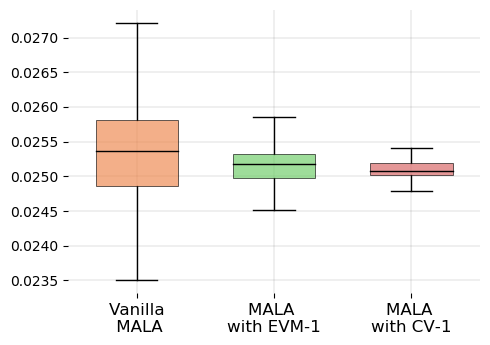

In [53]:
data = [res_arr_new[:,0,0],res_arr_new[:,0,1],res_arr_new[:,0,3]] 
boxplot_ind(data, title, labels, path = "results/ode/mala_delta_1.pdf")

In [54]:
title = ""
labels = ['Vanilla\n MALA', 'MALA \nwith EVM-2', 'MALA \nwith CV-2']

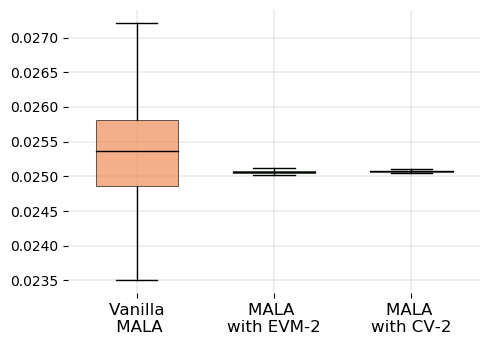

In [55]:
data = [res_arr_new[:,0,0],res_arr_new[:,0,2],res_arr_new[:,0,4]] 
boxplot_ind(data, title, labels, path = "results/ode/mala_delta_2_all.pdf")

In [56]:
title = ""
labels = ['MALA \nwith EVM-2', 'MALA \nwith CV-2']

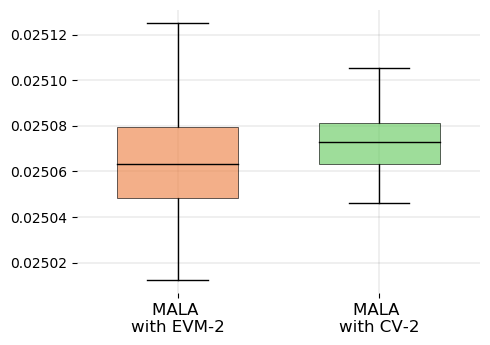

In [57]:
data = [res_arr_new[:,0,2],res_arr_new[:,0,4]] 
boxplot_ind(data, title, labels, path = "results/ode/mala_delta_2.pdf")